
<h1><center> Spectral Clustering & the Boston Housing Dataset  </center></h1>
<h2><center> MSDS5136  </center></h2>
<h3><center> 24 October, 2019 </center></h3>

******
### <center> Laura Gao | JR Waggoner
</center>

<img src='boston.jpeg' />

### Introdution
*****
The Boston Housing data is a relatively well-known dataset that is often used to introduce users to basic regression modeling techniques.  Though much attention has been given to modeling the data with various regresion-based methods, it appears that few have considered the data for classification purposes.   <br/>

Our goal is to experiment with the Boston data using a number of clustering and classification methods. We wish to explore the idea that regression-based methods may miss the existance of distinct classes within the data.


### Our Hypothesis
*****
#### H<sub>o</sub> = The data are homogenous and distinct clusters do not exist. <br/>
#### H<sub>a</sub> = The data are not homogenous and distinct clusters may exist.

### The Data:
****

In [32]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage

boston = load_boston()

boston.data
bos_df = pd.DataFrame(boston.data, columns = boston.feature_names)
bos_df['PRICE'] = boston.target

print(str(bos_df.shape) + ' Datframe Shape')
bos_df.head()

(506, 14) Datframe Shape


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
bos_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


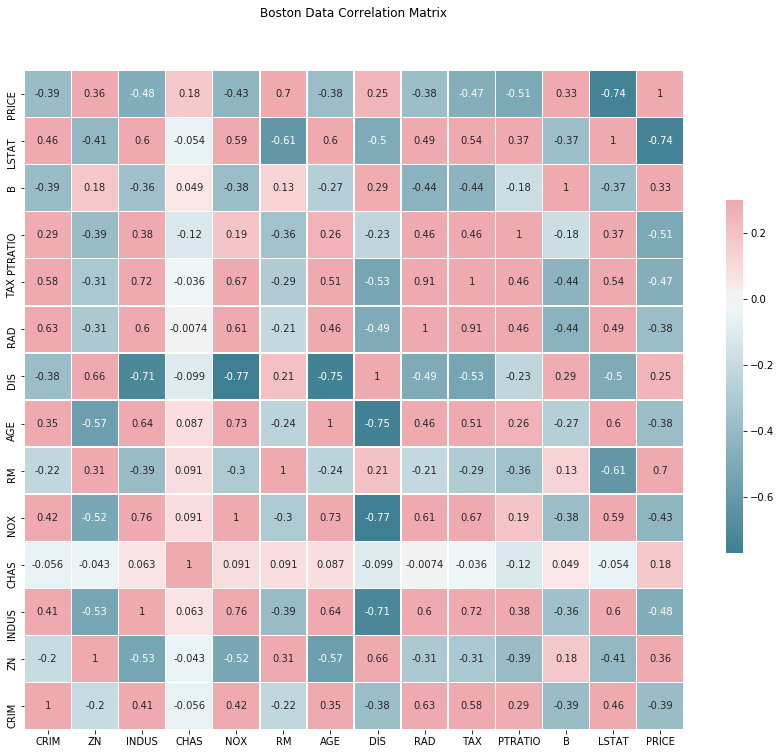

In [3]:
bos_corr = bos_df.corr()
cmap = sns.diverging_palette(220,10, as_cmap = True)
f,ax = plt.subplots(figsize = (15,13))
sns.heatmap(bos_corr, 
            cmap=cmap,
            vmax = .3,
            center = 0,
            square = True,
            linewidth = .5,
            annot = True,
            cbar_kws = {'shrink':.5})
plt.title('Boston Data Correlation Matrix')
plt.ylim(0,15)
plt.show()

## Part 1.
*****

### Unsupervised clustering

First, we consider the viability of clustering the Boston data by plotting the data with a dendrogram of a Ward-based hierarchical arrangement and visually inspect for clusters.  The plot suggests that there may be 3 or possibly 4 distinct clusters within the data.  

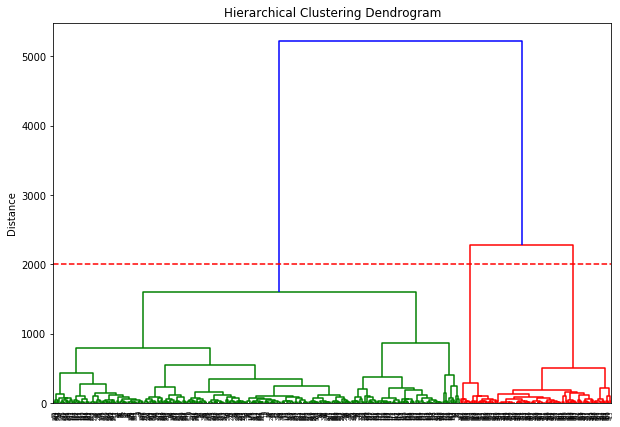

In [74]:
plt.figure(figsize=(10, 7))

dend = dendrogram(linkage(bos_df, method='ward'))
plt.axhline( y=2000, ls='--', c='red')
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.show()

We then build three cluster models - kmeans, spectral clustering, and agglomerative clustering - and evaluate their ability to define clusters by calculating the silhouette coefficient for each model.  

In [34]:
km_model = KMeans(3)
km_model.fit(bos_df)
km_labels = km_model.labels_

In [35]:
sc_model = SpectralClustering(n_clusters = 3,
                               assign_labels="discretize",
                               random_state=0,
                               #eigen_solver = 'lobpcg',
                               affinity = 'cosine',
                               #n_init = 6,
                               #n_neighbors = 20 
                             )
                                              
sc_model.fit(bos_df)
sc_labels = sc_model.labels_

In [36]:
ac_model = AgglomerativeClustering(n_clusters = 3)
ac_model.fit(bos_df)
ac_labels = ac_model.labels_

In [78]:
km_score3 = silhouette_score(bos_df, km_labels, metric='euclidean')
sc_score3 = silhouette_score(bos_df, sc_labels, metric='euclidean')
ac_score3 = silhouette_score(bos_df, ac_labels, metric='euclidean')

print('Silhouette scores for models at n = 3, higher is better: \n' )
print('KMeans: ' + str(km_score3) + '\n')
print('SpectralClustering: ' + str(sc_score3) + '\n')
print('AgglomerativeClustering: ' + str(ac_score3) + '\n')

Silhouette scores for models at n = 3, higher is better: 

KMeans: 0.7206329455984657

SpectralClustering: 0.2742461515936114

AgglomerativeClustering: 0.7181087630662963



And repeat the process for 2 data clusters:

In [80]:
km_model = KMeans(2)
km_model.fit(bos_df)
km_labels = km_model.labels_
sc_model = SpectralClustering(n_clusters = 2,
                               assign_labels="discretize",
                               random_state=0,
                               #eigen_solver = 'lobpcg',
                               affinity = 'cosine',
                               #n_init = 6,
                               #n_neighbors = 20 
                             )
                                              
sc_model.fit(bos_df)
sc_labels = sc_model.labels_

ac_model = AgglomerativeClustering(n_clusters = 2)
ac_model.fit(bos_df)
ac_labels = ac_model.labels_

km_score2= silhouette_score(bos_df, km_labels, metric='euclidean')
sc_score2= silhouette_score(bos_df, sc_labels, metric='euclidean')
ac_score2= silhouette_score(bos_df, ac_labels, metric='euclidean')

print('Silhouette scores for models at n = 2 higher is better: \n' )
print('KMeans: ' + str(km_score2) + '\n')
print('SpectralClustering: ' + str(sc_score2) + '\n')
print('AgglomerativeClustering: ' + str(ac_score2) + '\n')

Silhouette scores for models at n = 2 higher is better: 

KMeans: 0.6891842021666347

SpectralClustering: 0.6510760170021822

AgglomerativeClustering: 0.6891842021666347



And, finally, for 4 clusters:

In [81]:
km_model = KMeans(4)
km_model.fit(bos_df)
km_labels = km_model.labels_

sc_model = SpectralClustering(n_clusters = 4,
                               assign_labels="discretize",
                               random_state=0,
                               #eigen_solver = 'lobpcg',
                               affinity = 'cosine',
                               #n_init = 6,
                               #n_neighbors = 20 
                             )
                                              
sc_model.fit(bos_df)
sc_labels = sc_model.labels_

ac_model = AgglomerativeClustering(n_clusters = 4)
ac_model.fit(bos_df)
ac_labels = ac_model.labels_

km_score4 = silhouette_score(bos_df, km_labels, metric='euclidean')
sc_score4 = silhouette_score(bos_df, sc_labels, metric='euclidean')
ac_score4 = silhouette_score(bos_df, ac_labels, metric='euclidean')

print('Silhouette scores for models at n = 4, higher is better: \n' )
print('KMeans: ' + str(km_score4) + '\n')
print('SpectralClustering: ' + str(sc_score4) + '\n')
print('AgglomerativeClustering: ' + str(ac_score4) + '\n')

Silhouette scores for models at n = 4, higher is better: 

KMeans: 0.5626306156942926

SpectralClustering: 0.23087233189156978

AgglomerativeClustering: 0.5646575941008001



In [101]:
#Score Matrix
score_df = pd.DataFrame([[km_score2, km_score3, km_score4],
                        [sc_score2, sc_score3, sc_score4],
                        [ac_score2, ac_score3, ac_score4]],
                        index = ['KMeans','Spectral','Agglomerative'],
                        columns = ['N = 2', 'N=3', 'N=4'])                     
score_df

,N = 2,N=3,N=4
KMeans,0.689184,0.720633,0.562631
Spectral,0.651076,0.274246,0.230872
Agglomerative,0.689184,0.718109,0.564658


In [39]:
km_model = KMeans(3)
km_model.fit(bos_df)
km_labels = km_model.labels_

bos_df_ex = bos_df
bos_df_ex['kmeans_predicted'] = km_model.labels_

print(km_model.labels_)
bos_df_ex

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1
 1 2 1 1 1 1 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,kmeans_predicted
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4,0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6,0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9,0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0,0


And finally, we inspect a number of our data elements with the class labels from KMeans and 3 clusters applied: 

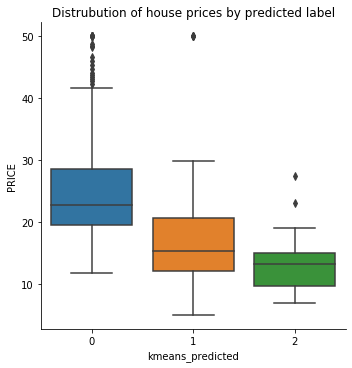

In [47]:
sns.catplot('kmeans_predicted',
            'PRICE',
            data = bos_df_ex,
           kind = 'box')
plt.title('Distrubution of house prices by predicted label')
plt.show()

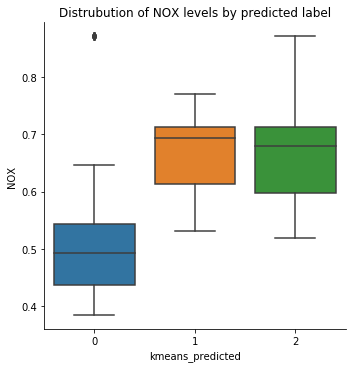

In [102]:
sns.catplot('kmeans_predicted',
            'NOX',
            data = bos_df_ex,
           kind = 'box')
plt.title('Distrubution of NOX levels by predicted label')
plt.show()

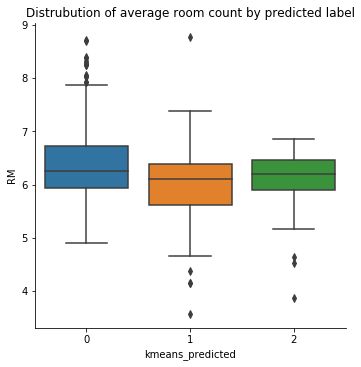

In [103]:
sns.catplot('kmeans_predicted',
            'RM',
            data = bos_df_ex,
           kind = 'box')
plt.title('Distrubution of average room count by predicted label')
plt.show()

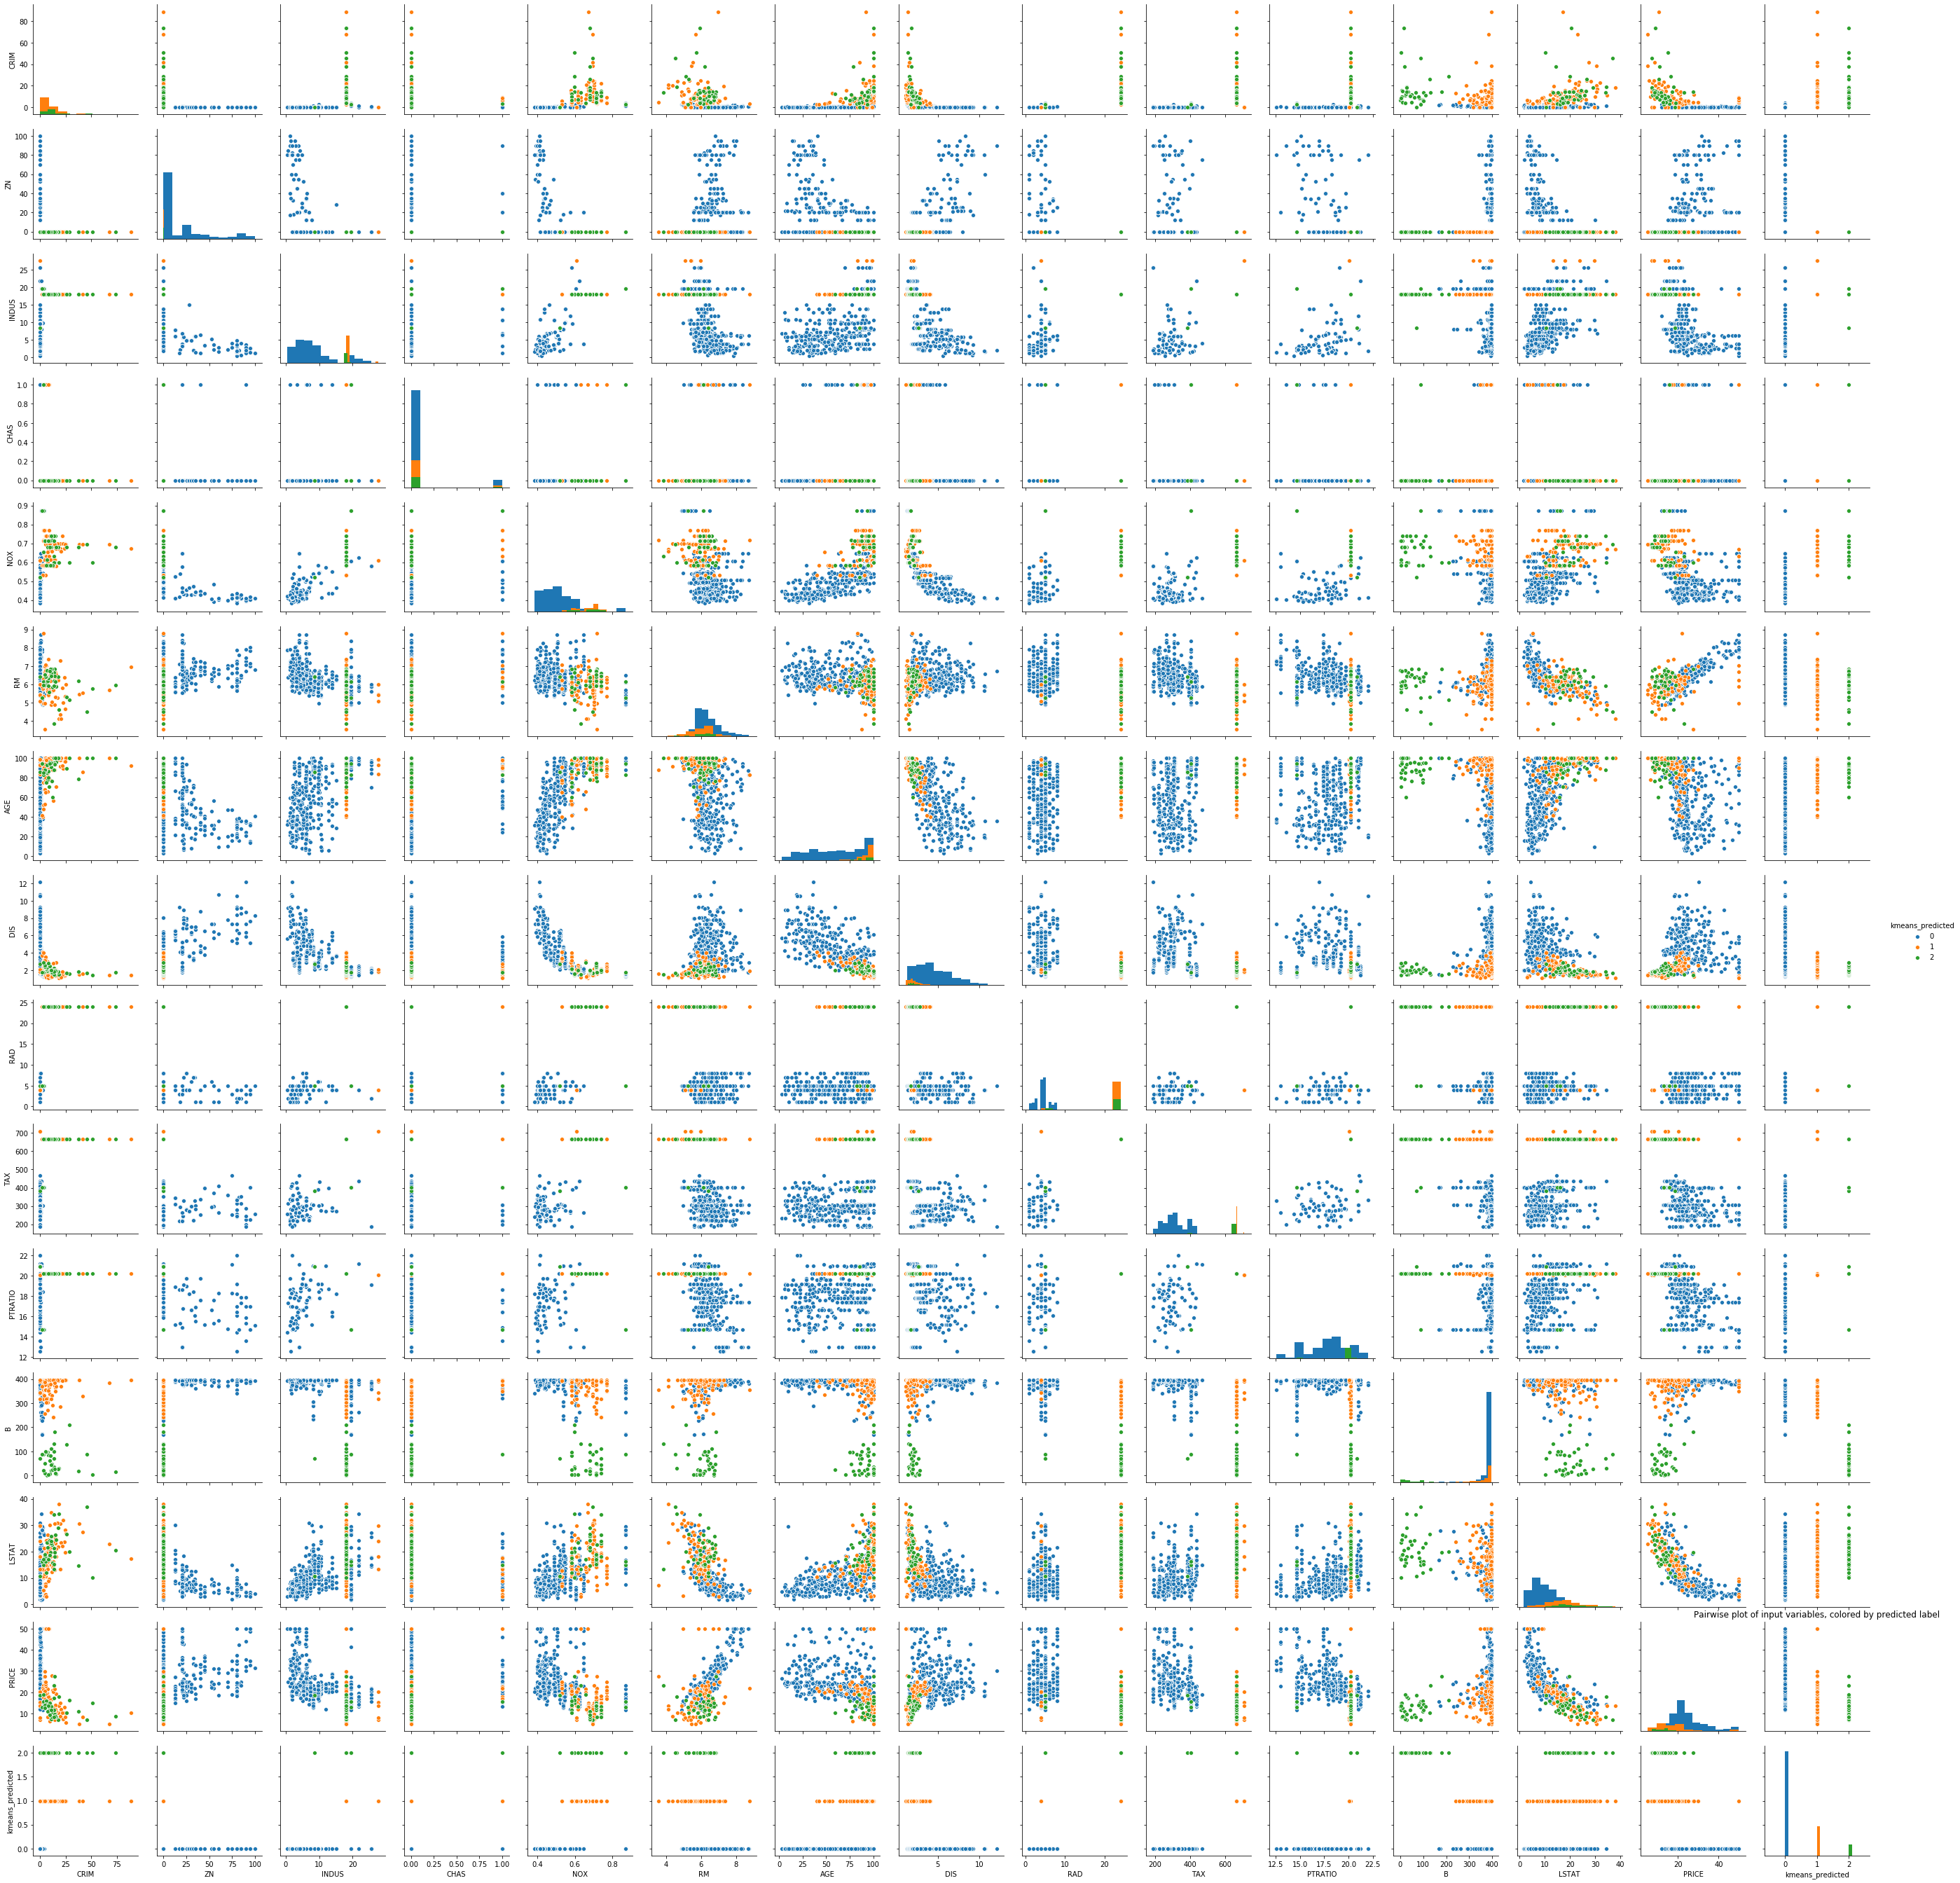

In [66]:
pairs = sns.pairplot(bos_df_ex.iloc[:,:-1],
                     diag_kind = 'hist', 
                     hue = 'kmeans_predicted')
plt.title('Pairwise plot of input variables, colored by predicted label')
plt.show()

After clustering the data with around the assumptions of 3, 4 and 6 clusters, the results of the silhouette tests suggest the algorithms create the most defined clusters when we model for 3 classes in the data.

## Part II.
****
### Discretizing the continuous output variable
****
The price of the houses in the dataset is continuous:

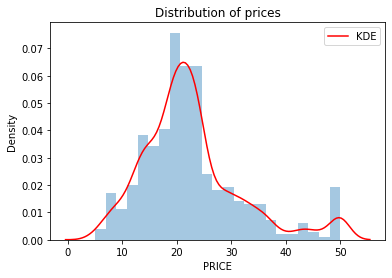

In [75]:
sns.distplot(bos_df['PRICE'],
            kde_kws={'color':'r','label': 'KDE'})
plt.title('Distribution of prices')
plt.ylabel('Density')
plt.show()

But we need discrete outcomes.  We ran a number of tests in which we grouped the continuous house price into a number of groups from 2 to 10.  2 discrete groups produced the best results.

In [51]:
# N will be used to define both the number of discrete groups for the output variable, 
# and the number of clusters for any clustering algorithms.
N = 3

In [52]:
#discretization with function

enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy = 'quantile')

enc.fit(bos_df['PRICE'].to_numpy().reshape(-1,1))

T = enc.transform(bos_df['PRICE'].to_numpy().reshape(-1,1))

bos_df['PRICE_BUCKET'] = T

In [104]:
boston.data
bos_df = pd.DataFrame(boston.data, columns = boston.feature_names)
bos_df['PRICE'] = boston.target
#discretization with function

enc = KBinsDiscretizer(n_bins=N, encode='ordinal', strategy = 'quantile')

enc.fit(bos_df['PRICE'].to_numpy().reshape(-1,1))

T = enc.transform(bos_df['PRICE'].to_numpy().reshape(-1,1))

bos_df['PRICE_BUCKET'] = T

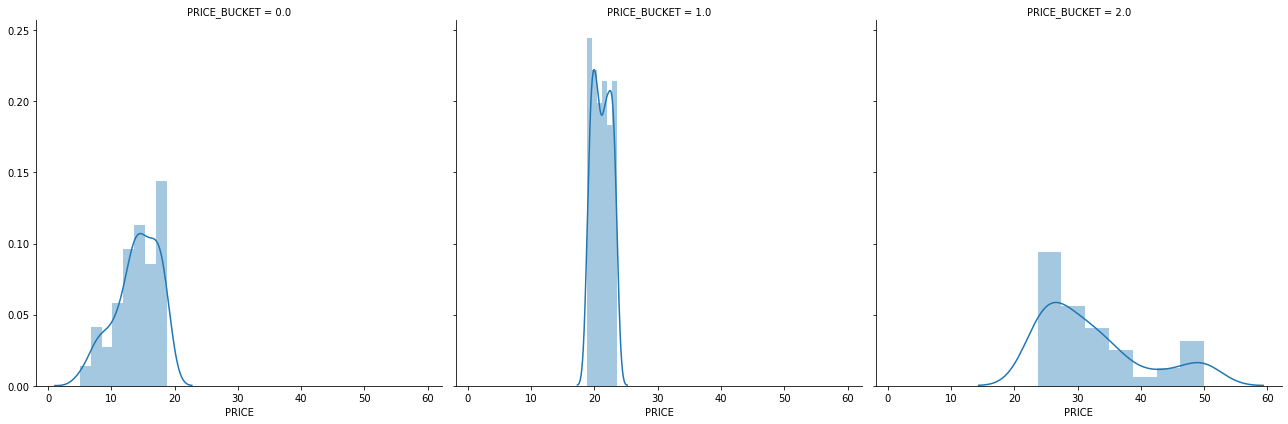

In [106]:
g = sns.FacetGrid(bos_df, col = 'PRICE_BUCKET', height = 6)
g.map(sns.distplot, 'PRICE')
plt.show()

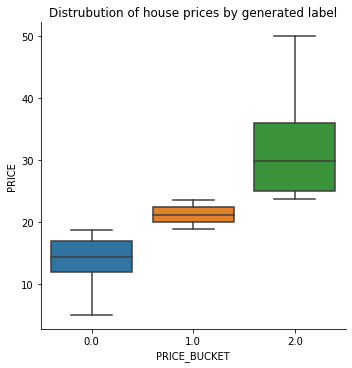

In [107]:
sns.catplot('PRICE_BUCKET',
            'PRICE',
            data = bos_df,
           kind = 'box')
plt.title('Distrubution of house prices by generated label')
plt.show()

Given the results of our unsupervised learning in part I, we continue our analysis using n = 3 clusters.

As an additional sanity check, we plot the pairwise plots of all the input variables colored by price bucket and visually inspect the data: 

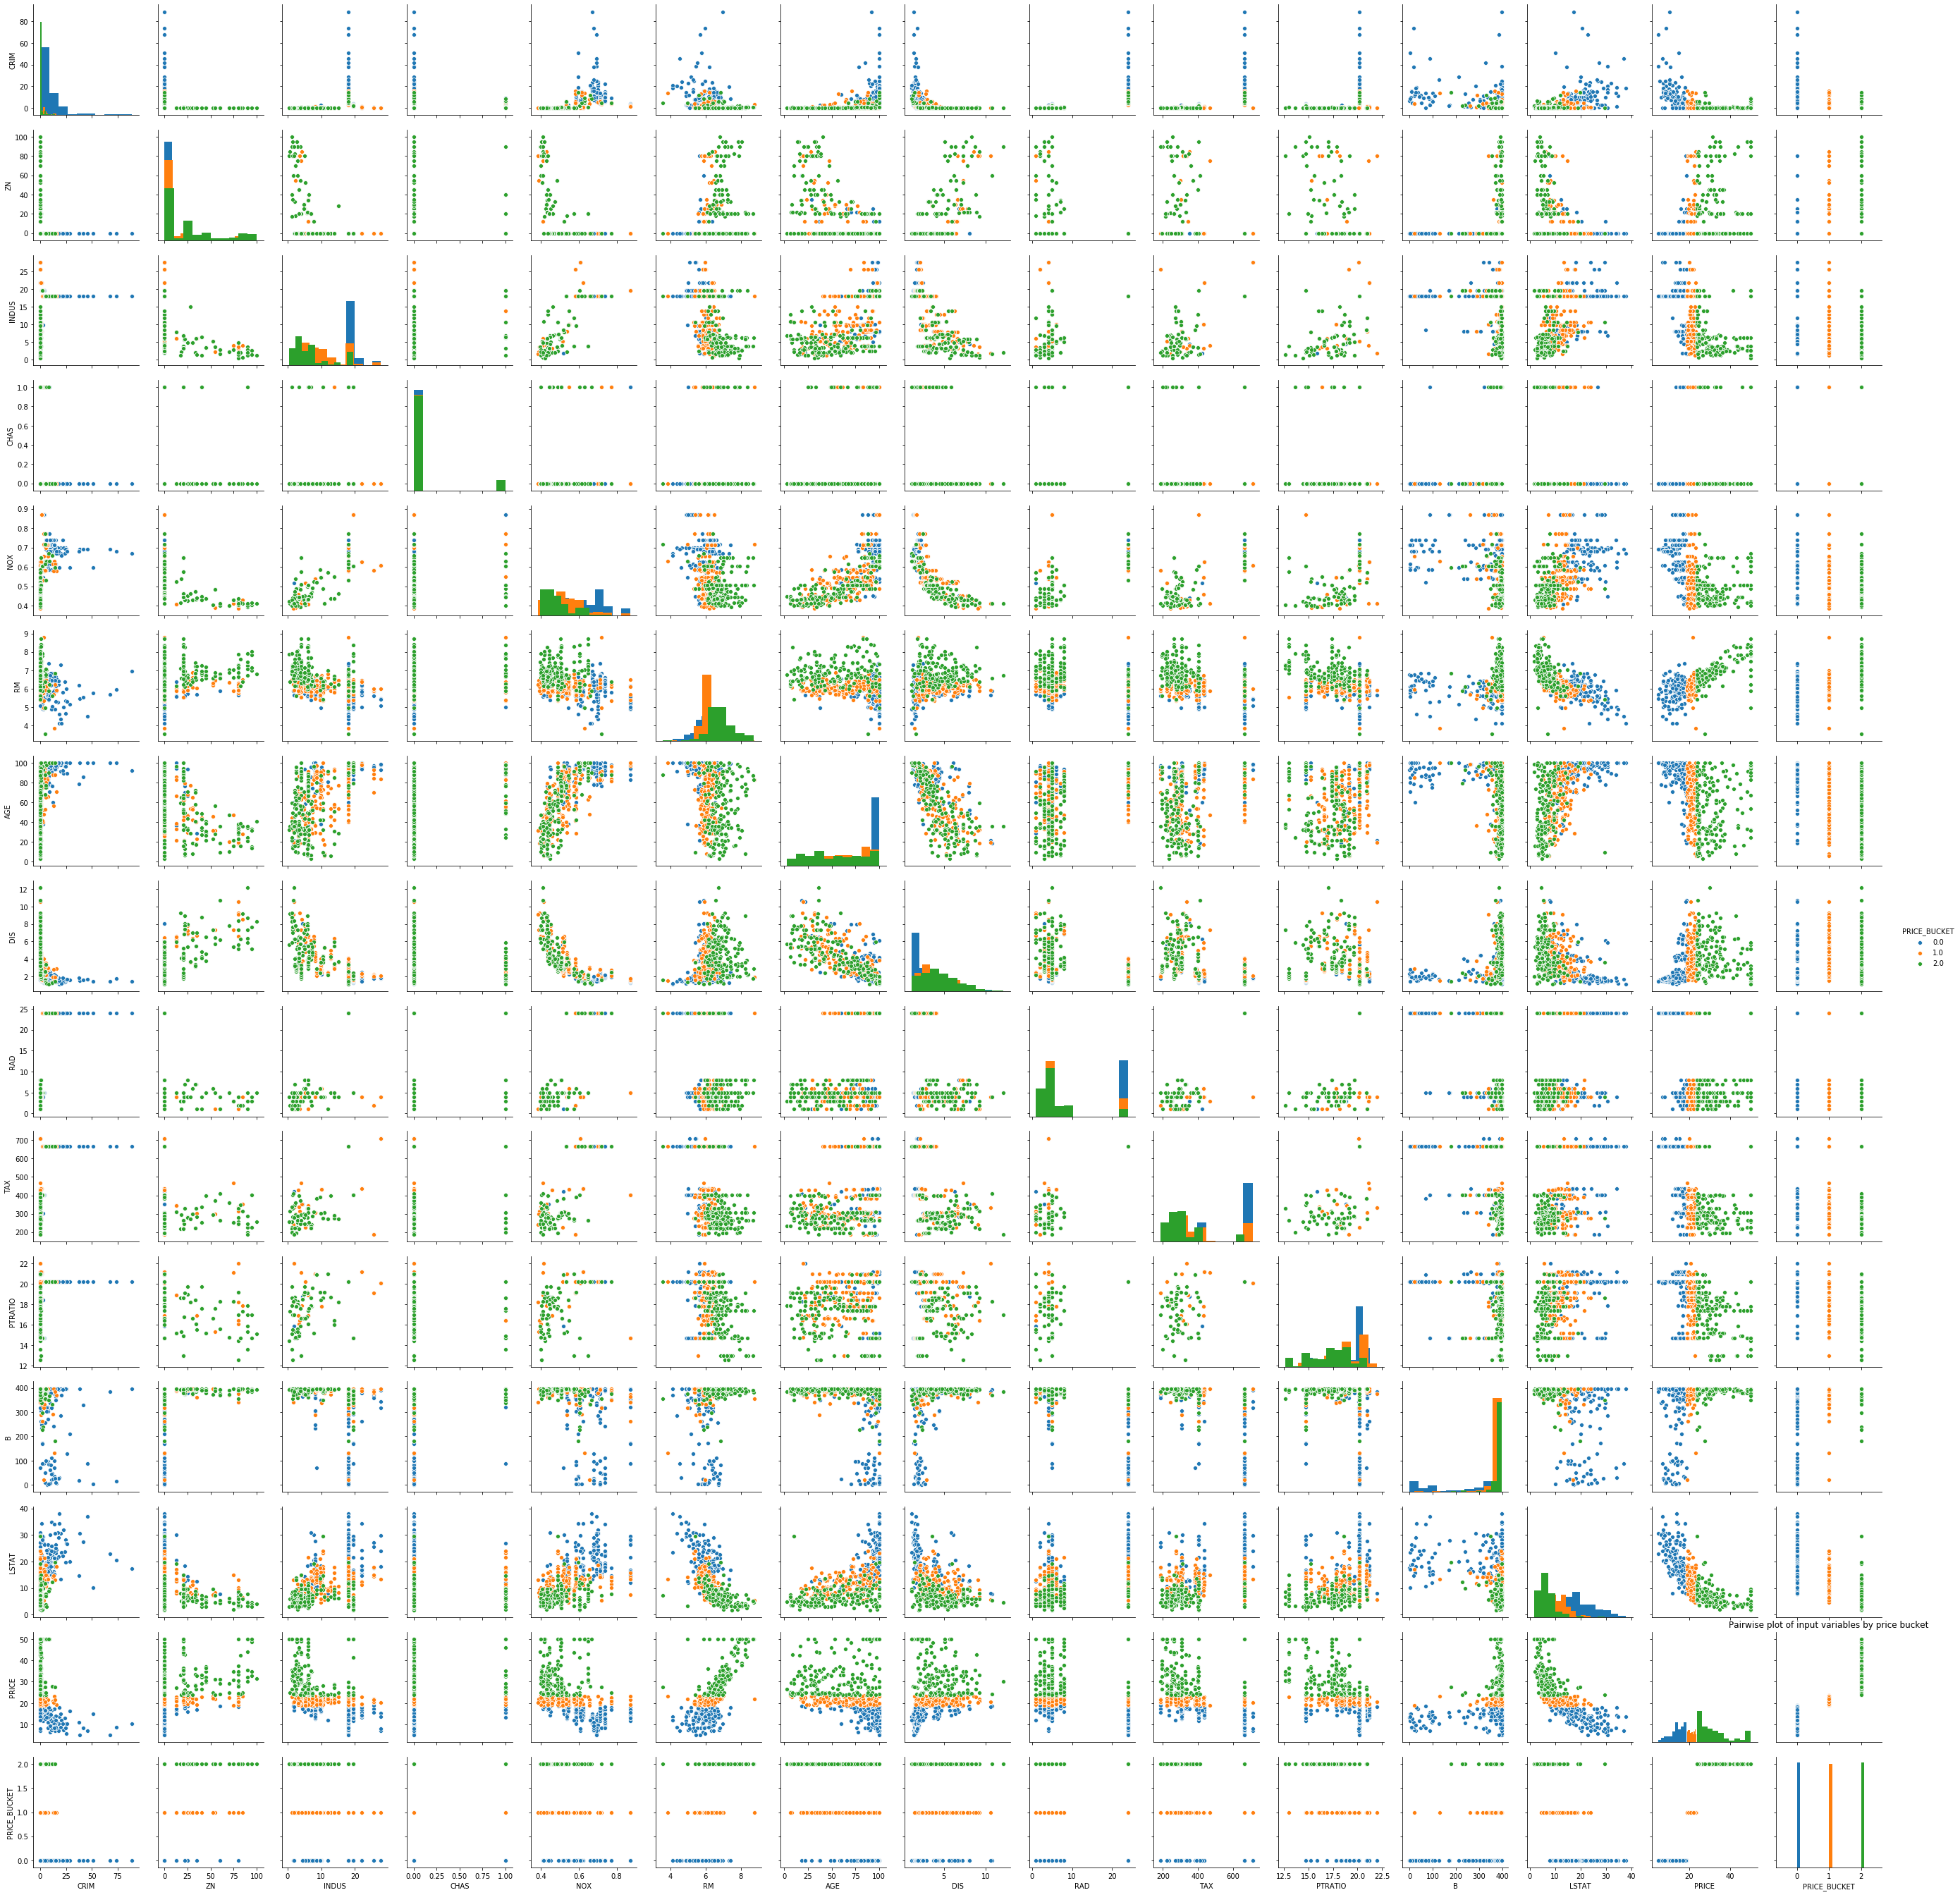

In [19]:
#f,ax = plt.subplots(figsize = (20,20))
pairs = sns.pairplot(bos_df, 
                     diag_kind = 'hist', 
                     hue = 'PRICE_BUCKET')
plt.title('Pairwise plot of input variables by price bucket')
plt.show()

In [17]:
#bos_df.drop('B', axis = 1, inplace = True)

x = bos_df.iloc[:,0:-2]
y = bos_df.iloc[:,-1]

### Modeling with SpectralClustering, KMeans, and a Decision Tree Classifier
***

spectral clustering model accuracy: 0.541501976284585


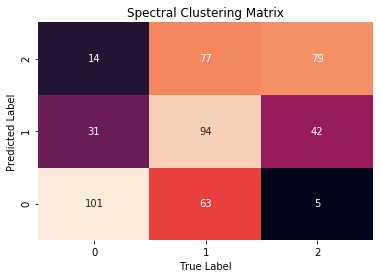

In [125]:
sc_model = SpectralClustering(n_clusters = N,
                           assign_labels="discretize",
                           random_state=0,
                           #eigen_solver = 'lobpcg',
                           affinity = 'linear',
                           #n_init = 6,
                           n_neighbors = 20
                          )
sc_model.fit(x)

labels = np.zeros_like(sc_model.labels_)

for i in range(3):
    mask = (sc_model.labels_ == i)
    labels[mask] = mode(y[mask])[0]

print("spectral clustering model accuracy: " + str(accuracy_score(y, labels)))
sc_result_mat = confusion_matrix(y,labels)

#print(result_mat)

mat_df = pd.DataFrame(sc_result_mat)

sns.heatmap(sc_result_mat,
            # square = True,
            annot = True,
            fmt = 'd',
            cbar = False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Spectral Clustering Matrix')
plt.ylim(0,3)
plt.show()

kmeans model accuracy: 0.5059288537549407


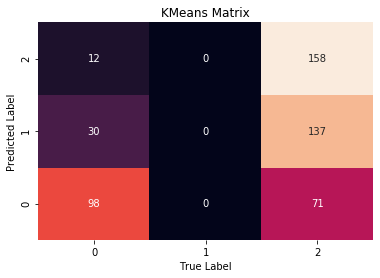

In [123]:
km_model = KMeans(N,
                  init = 'random',
                  n_init = 15,
                  max_iter = 400,
                  n_jobs = 10,
                 algorithm = 'auto')
km_model.fit(x)
labels = np.zeros_like(km_model.labels_)

for i in range(3): 
    mask = (km_model.labels_ == i)
    labels[mask] = mode(y[mask])[0]
    
print("kmeans model accuracy: " + str(accuracy_score(y, labels)))

km_result_mat = confusion_matrix(y,labels)

#print(result_mat)

mat_df = pd.DataFrame(km_result_mat)

sns.heatmap(km_result_mat,
            # square = True,
            annot = True,
            fmt = 'd',
            cbar = False)
        
plt.xlabel('True Label')
plt.ylabel('Predicted Label') 
plt.title('KMeans Matrix')
plt.ylim(0,3)
plt.show()

During the first run of our decision tree model, it was clear that we were overfitting the model to the data, so we performed a test/train split to help us pare back some of the model parameters and control the overfitting.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .30)

decision tree classifier model accuracy: 0.8983050847457628


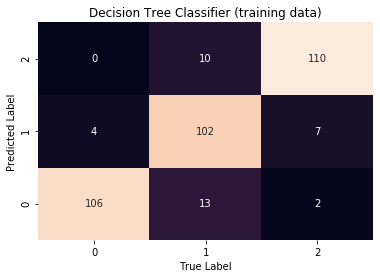

In [124]:
dt_model = dtc(max_depth = 5)
dt_model.fit(x_train,y_train)

pred = dt_model.predict(x_train)
labels = np.zeros_like(pred)

for i in range(3):
    mask = (pred == i)
    labels[mask] = mode(y_train[mask])[0]

print("decision tree classifier model accuracy: " + str(accuracy_score(y_train, pred)))
result_mat = confusion_matrix(y_train,pred)

#print(result_mat)

mat_df = pd.DataFrame(result_mat)

sns.heatmap(result_mat,
            # square = True,
            annot = True,
            fmt = 'd',
            cbar = False)
        
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Decision Tree Classifier (training data)')
plt.ylim(0,3)
plt.show()

decision tree classifier model accuracy: 0.7631578947368421


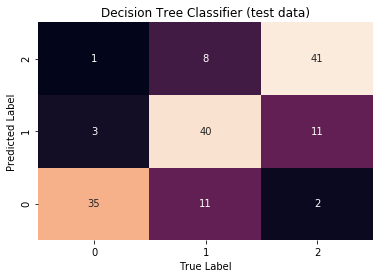

In [25]:
test = dt_model.predict(x_test)

print("decision tree classifier model accuracy: " + str(accuracy_score(y_test, test)))
dt_result_mat = confusion_matrix(y_test, test)

#print(result_mat)

mat_df = pd.DataFrame(dt_result_mat)

sns.heatmap(dt_result_mat,
           # square = True,
            annot = True,
            fmt = 'd',
            cbar = False)
        
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Decision Tree Classifier (test data)')
plt.ylim(0,3)
plt.show()

### Testing the model results
****

In [126]:
# chi^2 contingency test (EMT TEST?) to test the results of a 3x3 contingency table.
results = [sc_result_mat,
            km_result_mat,
            dt_result_mat]
  
chi2, p, dof, expected = chi2_contingency(sc_result_mat)
print('Spectral Clustering Model p-value: ' + str(p) + '\n')

"""kmeans misses classification of the second class in the data when using n = 3.  
Therefore, it does not produce any labels for the second class and the result matrix cannot be used 
(as-is) in the chi2 test."""
#chi2, p, dof, expected = chi2_contingency(km_result_mat)
#print('KMeans Model p-value: ' + str(p) + '\n')

chi2, p, dof, expected = chi2_contingency(dt_result_mat)
print('Decision Tree (test) Model p-value: ' + str(p) + '\n')
    

Spectral Clustering Model p-value: 3.569659563600302e-33

Decision Tree (test) Model p-value: 2.599274332356367e-28



### Conclusion
****
We set out to discover if distinct clusters existed in the Boston Housing dataset, and it appears that may be the case.  The data seem to suggest that there are three distinct groups of housing observations that diverge around PRICE = 21 and may fall into our generated 'low', 'medium', and 'high' price categories.  Becasue we opted to approach the dataset from a different modeling perspective, it would be 'apples-to-oranges' to compare our clustering results to typical regression-based outcomes.  However, a typical simple, multiple linear regression model will typically explain ~65% of the variation in the data with a root mean squared error of ~5.3 <sup>1</sup>.  We believe we've demonstrated there is a low probability that we obtained our clustering and classification results through random chance.  Therefore we reject our null hypothesis and conclude that the data are not homogeneous.

****
1. https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155 

*****
<img src='qm.svg.png' />